In [1]:
%load_ext jupyter_black
import torch
import torch.optim as optim
import torch.nn as nn
from optimizers.lsgd import LSGD
from optimizers.lrmsprop import LRMSprop
from optimizers.ladam import LAdam
from optimizers.ladadelta import LAdadelta
from optimizers.lsgd import APLSGD
import matplotlib.pyplot as plt
import numpy as np
import scienceplots
import tqdm
import math
from training.train import train, plot_langevin_loss
from diffusion.fishing import Fishing
from scheduler import PiecewiseConstantScheduler

plt.style.use(["science", "no-latex", "grid"])

seed = 42
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Single control:

In [2]:
train_batch = 512
test_batch = 512
train_size = 5
test_size = 25
epochs = 50

In [3]:
dim = 5

model_config = dict(
    T=1.0,
    N_euler=50,
    dim=dim,
    r=2 * torch.ones(dim),
    kappa=torch.Tensor(
        [
            [1.2, -0.1, 0.0, 0.0, -0.1],
            [0.2, 1.2, 0.0, 0.0, -0.1],
            [0.0, 0.2, 1.2, -0.1, 0.0],
            [0.0, 0.0, 0.1, 1.2, 0.0],
            [0.1, 0.1, 0.0, 0.0, 1.2],
        ]
    ),
    X_d=torch.ones(dim),
    u_m=0.01,
    u_M=1.0,
    alpha=0.01 * torch.ones(dim),
    beta=0.1,
    sigma=0.1 * torch.eye(dim),
    init_mean=torch.ones(dim),
    init_std=0.5,
    init_lbound=0.2,
    init_ubound=2,
)

control_config = dict(
    input_dim=1 + dim,
    output_dim=dim,
    hidden_dim=32,
    depth=2,
    activation=nn.ReLU(),
    out_transform=nn.Sigmoid(),
)

#### Adaptive Preconditionned SGD vs classic preconditionners

In [4]:
ocp = Fishing(**model_config)
ocp.set_control(control_config, multiple_controls=False)
aplsgd = APLSGD(ocp.control.parameters(), lr=5e-2, sigma=1e-3, momentum=0.9)
scheduler = PiecewiseConstantScheduler(
    aplsgd, target_lr=2e-4, target_sigma=0, total_iters=40
)

train_loss_aplsgd, test_loss_aplsgd, test_ci_aplsgd = train(
    ocp,
    aplsgd,
    scheduler,
    "APLSGD",
    epochs,
    train_size,
    test_size,
    train_batch,
    test_batch,
)

Fishing: Epoch 49, APLSGD, lr=0.000, sigma=[0], train=0.383, test=0.379: 100%|██████████| 50/50 [00:14<00:00,  3.36it/s]    


In [5]:
ocp = Fishing(**model_config)
ocp.set_control(control_config, multiple_controls=False)
adam = optim.Adam(ocp.control.parameters(), lr=2e-3)
scheduler = PiecewiseConstantScheduler(
    adam, target_lr=2e-4, target_sigma=0, total_iters=40
)

train_loss_adam, test_loss_adam, test_ci_adam = train(
    ocp, adam, scheduler, "Adam", epochs, train_size, test_size, train_batch, test_batch
)

Fishing: Epoch 49, Adam, lr=0.000, sigma=[0], train=0.341, test=0.332: 100%|██████████| 50/50 [00:14<00:00,  3.40it/s]


In [6]:
ocp = Fishing(**model_config)
ocp.set_control(control_config, multiple_controls=False)
adadelta = optim.Adadelta(ocp.control.parameters(), lr=5e-1)
scheduler = PiecewiseConstantScheduler(
    adadelta, target_lr=5e-2, target_sigma=0, total_iters=40
)

train_loss_adadelta, test_loss_adadelta, test_ci_adadelta = train(
    ocp,
    adadelta,
    scheduler,
    "Adadelta",
    epochs,
    train_size,
    test_size,
    train_batch,
    test_batch,
)

Fishing: Epoch 49, Adadelta, lr=0.050, sigma=[0], train=0.439, test=0.433: 100%|██████████| 50/50 [00:14<00:00,  3.46it/s]


In [7]:
ocp = Fishing(**model_config)
ocp.set_control(control_config, multiple_controls=False)
rmsprop = optim.RMSprop(ocp.control.parameters(), lr=2e-3)
scheduler = PiecewiseConstantScheduler(
    rmsprop, target_lr=2e-4, target_sigma=0, total_iters=40
)

train_loss_rmsprop, test_loss_rmsprop, test_ci_rmsprop = train(
    ocp,
    rmsprop,
    scheduler,
    "RMSprop",
    epochs,
    train_size,
    test_size,
    train_batch,
    test_batch,
)

Fishing: Epoch 49, RMSprop, lr=0.000, sigma=[0], train=0.295, test=0.295: 100%|██████████| 50/50 [00:14<00:00,  3.39it/s]


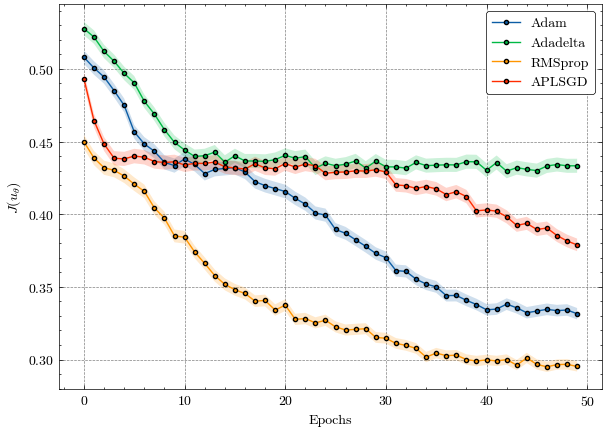

In [8]:
fig = plt.figure(figsize=(7, 5))
plt.plot(
    np.arange(len(test_loss_adam)),
    test_loss_adam,
    marker="o",
    mec="k",
    ms=3,
    label="Adam",
)
plt.fill_between(
    np.arange(len(test_loss_adam)),
    np.array(test_loss_adam) - np.array(test_ci_adam),
    np.array(test_loss_adam) + np.array(test_ci_adam),
    alpha=0.2,
)
plt.plot(
    np.arange(len(test_loss_adadelta)),
    test_loss_adadelta,
    marker="o",
    mec="k",
    ms=3,
    label="Adadelta",
)
plt.fill_between(
    np.arange(len(test_loss_adadelta)),
    np.array(test_loss_adadelta) - np.array(test_ci_adadelta),
    np.array(test_loss_adadelta) + np.array(test_ci_adadelta),
    alpha=0.2,
)
plt.plot(
    np.arange(len(test_loss_rmsprop)),
    test_loss_rmsprop,
    marker="o",
    mec="k",
    ms=3,
    label="RMSprop",
)
plt.fill_between(
    np.arange(len(test_loss_rmsprop)),
    np.array(test_loss_rmsprop) - np.array(test_ci_rmsprop),
    np.array(test_loss_rmsprop) + np.array(test_ci_rmsprop),
    alpha=0.2,
)
plt.plot(
    np.arange(len(test_loss_aplsgd)),
    test_loss_aplsgd,
    marker="o",
    mec="k",
    ms=3,
    label=f"APLSGD",
)
plt.fill_between(
    np.arange(len(test_loss_aplsgd)),
    np.array(test_loss_aplsgd) - np.array(test_ci_aplsgd),
    np.array(test_loss_aplsgd) + np.array(test_ci_aplsgd),
    alpha=0.2,
)
legend = plt.legend(fancybox=True, edgecolor="k", loc=0)
legend.get_frame().set_linewidth(0.5)
plt.xlabel("Epochs")
plt.ylabel(r"$J(u_\theta)$")

plt.show()
plt.close()

#### Preconditionned Langevin

In [9]:
ocp = Fishing(**model_config)
ocp.set_control(control_config, multiple_controls=False)
adam = optim.Adam(ocp.control.parameters(), lr=2e-3)
scheduler = PiecewiseConstantScheduler(
    adam, target_lr=2e-4, target_sigma=0, total_iters=40
)

train_loss_adam, test_loss_adam, test_ci_adam = train(
    ocp, adam, scheduler, "Adam", epochs, train_size, test_size, train_batch, test_batch
)

Fishing: Epoch 49, Adam, lr=0.000, sigma=[0], train=0.327, test=0.324: 100%|██████████| 50/50 [00:14<00:00,  3.37it/s]


In [10]:
ocp = Fishing(**model_config)
ocp.set_control(control_config, multiple_controls=False)
ladam = LAdam(ocp.control.parameters(), lr=2e-3, sigma=1e-3)
scheduler = PiecewiseConstantScheduler(
    ladam, target_lr=2e-4, target_sigma=0, total_iters=40
)

train_loss_ladam, test_loss_ladam, test_ci_ladam = train(
    ocp,
    ladam,
    scheduler,
    "LAdam",
    epochs,
    train_size,
    test_size,
    train_batch,
    test_batch,
)

Fishing: Epoch 49, LAdam, lr=0.000, sigma=[0], train=0.303, test=0.302: 100%|██████████| 50/50 [00:18<00:00,  2.70it/s]    


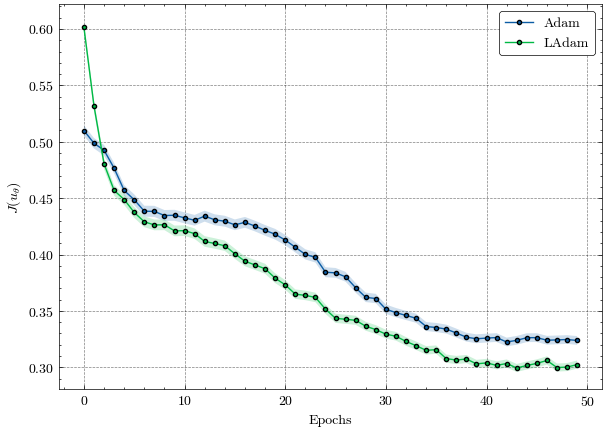

In [11]:
plot_langevin_loss(
    test_loss_adam, test_ci_adam, test_loss_ladam, test_ci_ladam, name="Adam"
)

In [12]:
ocp = Fishing(**model_config)
ocp.set_control(control_config, multiple_controls=False)
adadelta = optim.Adadelta(ocp.control.parameters(), lr=5e-1)
scheduler = PiecewiseConstantScheduler(
    adadelta, target_lr=5e-2, target_sigma=0, total_iters=40
)

train_loss_adadelta, test_loss_adadelta, test_ci_adadelta = train(
    ocp,
    adadelta,
    scheduler,
    "Adadelta",
    epochs,
    train_size,
    test_size,
    train_batch,
    test_batch,
)

Fishing: Epoch 49, Adadelta, lr=0.050, sigma=[0], train=0.440, test=0.431: 100%|██████████| 50/50 [00:16<00:00,  3.10it/s]


In [13]:
ocp = Fishing(**model_config)
ocp.set_control(control_config, multiple_controls=False)
ladadelta = LAdadelta(ocp.control.parameters(), lr=5e-1, sigma=1e-2)
scheduler = PiecewiseConstantScheduler(
    ladadelta, target_lr=5e-2, target_sigma=0, total_iters=40
)

train_loss_ladadelta, test_loss_ladadelta, test_ci_ladadelta = train(
    ocp,
    ladadelta,
    scheduler,
    "Adadelta",
    epochs,
    train_size,
    test_size,
    train_batch,
    test_batch,
)

Fishing: Epoch 49, Adadelta, lr=0.050, sigma=[0], train=0.277, test=0.281: 100%|██████████| 50/50 [00:16<00:00,  2.99it/s]   


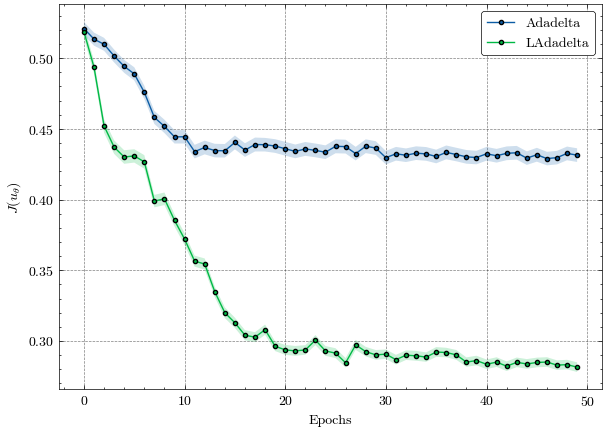

In [14]:
plot_langevin_loss(
    test_loss_adadelta,
    test_ci_adadelta,
    test_loss_ladadelta,
    test_ci_ladadelta,
    name="Adadelta",
)

In [15]:
ocp = Fishing(**model_config)
ocp.set_control(control_config, multiple_controls=False)
rmsprop = optim.RMSprop(ocp.control.parameters(), lr=2e-3)
scheduler = PiecewiseConstantScheduler(
    rmsprop, target_lr=2e-4, target_sigma=0, total_iters=40
)

train_loss_rmsprop, test_loss_rmsprop, test_ci_rmsprop = train(
    ocp,
    rmsprop,
    scheduler,
    "RMSprop",
    epochs,
    train_size,
    test_size,
    train_batch,
    test_batch,
)

Fishing: Epoch 49, RMSprop, lr=0.000, sigma=[0], train=0.310, test=0.306: 100%|██████████| 50/50 [00:17<00:00,  2.91it/s]


In [16]:
ocp = Fishing(**model_config)
ocp.set_control(control_config, multiple_controls=False)
lrmsprop = LRMSprop(ocp.control.parameters(), lr=2e-3, sigma=5e-3)
scheduler = PiecewiseConstantScheduler(
    lrmsprop, target_lr=2e-4, target_sigma=0, total_iters=40
)
epochs = 50

train_loss_lrmsprop, test_loss_lrmsprop, test_ci_lrmsprop = train(
    ocp,
    lrmsprop,
    scheduler,
    "LRMSprop",
    epochs,
    train_size,
    test_size,
    train_batch,
    test_batch,
)

Fishing: Epoch 49, LRMSprop, lr=0.000, sigma=[0], train=0.287, test=0.284: 100%|██████████| 50/50 [00:16<00:00,  2.96it/s]    


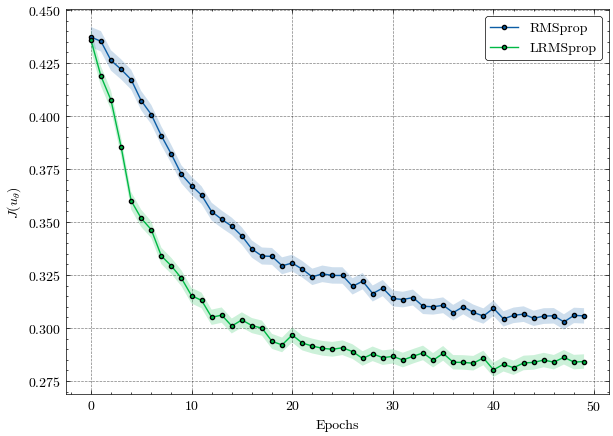

In [17]:
plot_langevin_loss(
    test_loss_rmsprop,
    test_ci_rmsprop,
    test_loss_lrmsprop,
    test_ci_lrmsprop,
    name="RMSprop",
)

### Multiple controls:

In [18]:
dim = 5

model_config = dict(
    T=1.0,
    N_euler=20,
    dim=dim,
    r=2 * torch.ones(dim),
    kappa=torch.Tensor(
        [
            [1.2, -0.1, 0.0, 0.0, -0.1],
            [0.2, 1.2, 0.0, 0.0, -0.1],
            [0.0, 0.2, 1.2, -0.1, 0.0],
            [0.0, 0.0, 0.1, 1.2, 0.0],
            [0.1, 0.1, 0.0, 0.0, 1.2],
        ]
    ),
    X_d=torch.ones(dim),
    u_m=0.01,
    u_M=1.0,
    alpha=0.01 * torch.ones(dim),
    beta=0.1,
    sigma=0.1 * torch.eye(dim),
    init_mean=torch.ones(dim),
    init_std=0.5,
    init_lbound=0.2,
    init_ubound=2,
)

control_config = dict(
    input_dim=5,
    output_dim=5,
    hidden_dim=32,
    depth=2,
    activation=nn.ReLU(),
    out_transform=nn.Sigmoid(),
)

In [19]:
ocp = Fishing(**model_config)
ocp.set_control(control_config, multiple_controls=True)
adam = [optim.Adam(control.parameters(), lr=2e-3) for control in ocp.control]
scheduler = [
    PiecewiseConstantScheduler(opt, target_lr=2e-4, target_sigma=0, total_iters=40)
    for opt in adam
]

train_loss_adam, test_loss_adam, test_ci_adam = train(
    ocp, adam, scheduler, "Adam", epochs, train_size, test_size, train_batch, test_batch
)

Fishing: Epoch 49, Adam, lr=0.000, sigma=[0], train=0.339, test=0.332: 100%|██████████| 50/50 [00:07<00:00,  6.69it/s]


In [20]:
ocp = Fishing(**model_config)
ocp.set_control(control_config, multiple_controls=True)
ladam = [LAdam(control.parameters(), lr=2e-3, sigma=1e-3) for control in ocp.control]
scheduler = [
    PiecewiseConstantScheduler(opt, target_lr=2e-4, target_sigma=0, total_iters=40)
    for opt in ladam
]

train_loss_ladam, test_loss_ladam, test_ci_ladam = train(
    ocp,
    ladam,
    scheduler,
    "LAdam",
    epochs,
    train_size,
    test_size,
    train_batch,
    test_batch,
)

Fishing: Epoch 49, LAdam, lr=0.000, sigma=[0], train=0.384, test=0.383: 100%|██████████| 50/50 [00:08<00:00,  6.17it/s]    


In [21]:
ocp = Fishing(**model_config)
ocp.set_control(control_config, multiple_controls=True)
ll = 10  # Langevin Layer percentage
lladam = []
for i, control in enumerate(ocp.control):
    if 100 * i / len(ocp.control) <= ll:
        lladam.append(LAdam(control.parameters(), lr=2e-3, sigma=1e-3))
    else:
        lladam.append(optim.Adam(control.parameters(), lr=2e-3))
scheduler = [
    PiecewiseConstantScheduler(opt, target_lr=2e-4, target_sigma=0, total_iters=40)
    for opt in lladam
]

train_loss_ll10adam, test_loss_ll10adam, test_ci_ll10adam = train(
    ocp,
    lladam,
    scheduler,
    "LLAdam",
    epochs,
    train_size,
    test_size,
    train_batch,
    test_batch,
)

Fishing: Epoch 49, LLAdam, lr=0.000, sigma=[0], train=0.356, test=0.360: 100%|██████████| 50/50 [00:07<00:00,  6.64it/s]


In [22]:
ocp = Fishing(**model_config)
ocp.set_control(control_config, multiple_controls=True)
ll = 90  # Langevin Layer percentage
lladam = []
for i, control in enumerate(ocp.control):
    if 100 * i / len(ocp.control) <= ll:
        lladam.append(LAdam(control.parameters(), lr=2e-3, sigma=1e-3))
    else:
        lladam.append(optim.Adam(control.parameters(), lr=2e-3))
scheduler = [
    PiecewiseConstantScheduler(opt, target_lr=2e-4, target_sigma=0, total_iters=40)
    for opt in lladam
]

train_loss_ll90adam, test_loss_ll90adam, test_ci_ll90adam = train(
    ocp,
    lladam,
    scheduler,
    "LLAdam",
    epochs,
    train_size,
    test_size,
    train_batch,
    test_batch,
)

Training Fishing with LLAdam:   0%|          | 0/50 [00:00<?, ?it/s]

Fishing: Epoch 49, LLAdam, lr=0.000, sigma=[0], train=0.383, test=0.387: 100%|██████████| 50/50 [00:08<00:00,  6.08it/s]


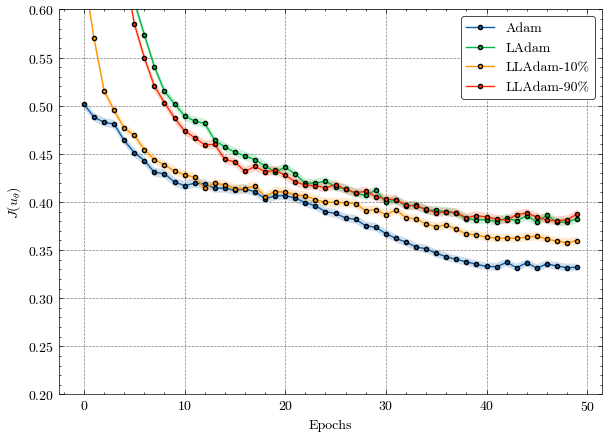

In [23]:
plot_langevin_loss(
    test_loss_adam,
    test_ci_adam,
    test_loss_ladam,
    test_ci_ladam,
    [test_loss_ll10adam, test_loss_ll90adam],
    [test_ci_ll10adam, test_ci_ll90adam],
    ll=[10, 90],
    name="Adam",
    ylim=(0.2, 0.6),
)

In [24]:
ocp = Fishing(**model_config)
ocp.set_control(control_config, multiple_controls=True)
adadelta = [
    optim.Adadelta(control.parameters(), lr=5e-1, rho=0.95) for control in ocp.control
]
scheduler = [
    PiecewiseConstantScheduler(opt, target_lr=5e-2, target_sigma=0, total_iters=40)
    for opt in adam
]
epochs = 50

train_loss_adadelta, test_loss_adadelta, test_ci_adadelta = train(
    ocp,
    adadelta,
    scheduler,
    "Adadelta",
    epochs,
    train_size,
    test_size,
    train_batch,
    test_batch,
)

Fishing: Epoch 49, Adadelta, lr=0.050, sigma=[0], train=0.463, test=0.460: 100%|██████████| 50/50 [00:07<00:00,  6.32it/s]


In [25]:
ocp = Fishing(**model_config)
ocp.set_control(control_config, multiple_controls=True)
ladadelta = [
    LAdadelta(control.parameters(), lr=5e-1, sigma=5e-3) for control in ocp.control
]
scheduler = [
    PiecewiseConstantScheduler(opt, target_lr=5e-2, target_sigma=0, total_iters=40)
    for opt in adam
]

train_loss_ladadelta, test_loss_ladadelta, test_ci_ladadelta = train(
    ocp,
    ladadelta,
    scheduler,
    "LAdadelta",
    epochs,
    train_size,
    test_size,
    train_batch,
    test_batch,
)

Fishing: Epoch 49, LAdadelta, lr=0.050, sigma=[0], train=0.414, test=0.410: 100%|██████████| 50/50 [00:08<00:00,  6.04it/s]


In [26]:
ocp = Fishing(**model_config)
ocp.set_control(control_config, multiple_controls=True)
ll = 10  # Langevin Layer percentage
lladadelta = []
for i, control in enumerate(ocp.control):
    if 100 * (i + 1) / len(ocp.control) <= ll:
        lladadelta.append(LAdadelta(control.parameters(), lr=5e-1, sigma=5e-3))
    else:
        lladadelta.append(optim.Adadelta(control.parameters(), lr=5e-1, rho=0.95))
scheduler = [
    PiecewiseConstantScheduler(opt, target_lr=5e-2, target_sigma=0, total_iters=40)
    for opt in lladadelta
]
epochs = 50

train_loss_ll10adadelta, test_loss_ll10adadelta, test_ci_ll10adadelta = train(
    ocp,
    lladadelta,
    scheduler,
    "LLAdadelta",
    epochs,
    train_size,
    test_size,
    train_batch,
    test_batch,
)

Fishing: Epoch 49, LLAdadelta, lr=0.050, sigma=[0], train=0.457, test=0.453: 100%|██████████| 50/50 [00:07<00:00,  6.61it/s]


In [27]:
ocp = Fishing(**model_config)
ocp.set_control(control_config, multiple_controls=True)
ll = 90  # Langevin Layer percentage
lladadelta = []
for i, control in enumerate(ocp.control):
    if 100 * (i + 1) / len(ocp.control) <= ll:
        lladadelta.append(LAdadelta(control.parameters(), lr=5e-1, sigma=5e-3))
    else:
        lladadelta.append(optim.Adadelta(control.parameters(), lr=5e-1, rho=0.95))
scheduler = [
    PiecewiseConstantScheduler(opt, target_lr=5e-2, target_sigma=0, total_iters=40)
    for opt in lladadelta
]
epochs = 50

train_loss_ll90adadelta, test_loss_ll90adadelta, test_ci_ll90adadelta = train(
    ocp,
    lladadelta,
    scheduler,
    "LLAdadelta",
    epochs,
    train_size,
    test_size,
    train_batch,
    test_batch,
)

Fishing: Epoch 49, LLAdadelta, lr=0.050, sigma=[0], train=0.413, test=0.419: 100%|██████████| 50/50 [00:07<00:00,  6.26it/s]


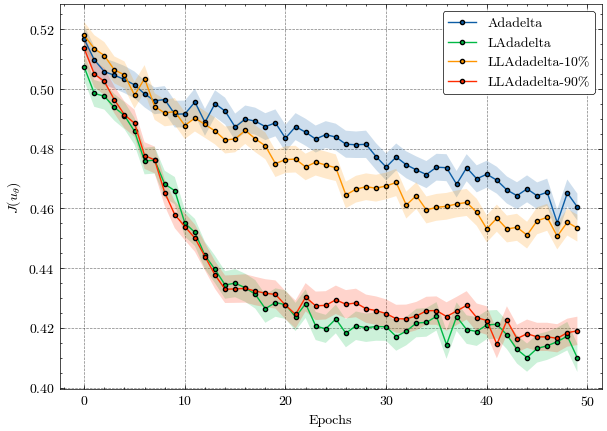

In [28]:
plot_langevin_loss(
    test_loss_adadelta,
    test_ci_adadelta,
    test_loss_ladadelta,
    test_ci_ladadelta,
    [test_loss_ll10adadelta, test_loss_ll90adadelta],
    [test_ci_ll10adadelta, test_ci_ll90adadelta],
    ll=[10, 90],
    name="Adadelta",
)

### Sample trajectory:

In [29]:
dim = 5

model_config = dict(
    T=1.0,
    N_euler=50,
    dim=dim,
    r=2 * torch.ones(dim),
    kappa=torch.Tensor(
        [
            [1.2, -0.1, 0.0, 0.0, -0.1],
            [0.2, 1.2, 0.0, 0.0, -0.1],
            [0.0, 0.2, 1.2, -0.1, 0.0],
            [0.0, 0.0, 0.1, 1.2, 0.0],
            [0.1, 0.1, 0.0, 0.0, 1.2],
        ]
    ),
    X_d=torch.ones(dim),
    u_m=0.01,
    u_M=1.0,
    alpha=0.01 * torch.ones(dim),
    beta=0.1,
    sigma=0.1 * torch.eye(dim),
    init_mean=torch.ones(dim),
    init_std=0.5,
    init_lbound=0.2,
    init_ubound=2,
)

control_config = dict(
    input_dim=1 + dim,
    output_dim=dim,
    hidden_dim=32,
    depth=2,
    activation=nn.ReLU(),
    out_transform=nn.Sigmoid(),
)

In [30]:
ocp = Fishing(**model_config)
ocp.set_control(control_config, multiple_controls=False)
adam = optim.Adam(ocp.control.parameters(), lr=2e-3)
scheduler = PiecewiseConstantScheduler(
    adam, target_lr=2e-4, target_sigma=0, total_iters=40
)

train_loss_adam, test_loss_adam, test_ci_adam = train(
    ocp, adam, scheduler, "Adam", epochs, train_size, test_size, train_batch, test_batch
)

Fishing: Epoch 49, Adam, lr=0.000, sigma=[0], train=0.321, test=0.323: 100%|██████████| 50/50 [00:17<00:00,  2.82it/s]


In [31]:
X, u = ocp.sample_traj(1)

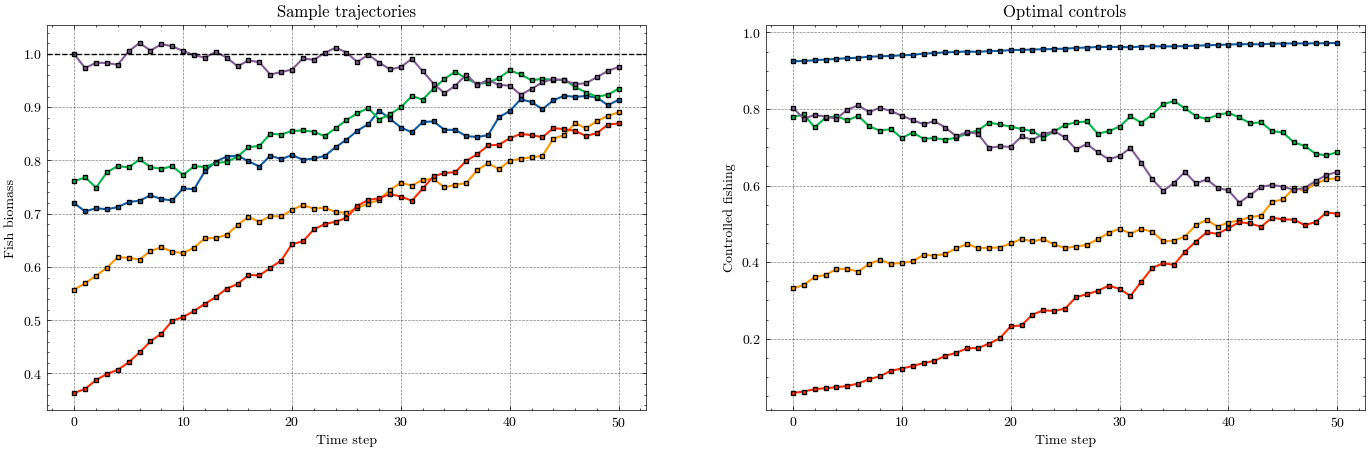

In [32]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(17, 5))

for k in range(X.shape[2]):
    ax1.plot(X[:, :, k].flatten().detach().numpy(), lw=1.5, marker="s", mec="k", ms=3)
    ax2.plot(u[:, :, k].flatten().detach().numpy(), lw=1.5, marker="s", mec="k", ms=3)
ax1.axhline(1, linestyle="--", color="k")
ax1.set_title("Sample trajectories")
ax1.set_xlabel("Time step")
ax1.set_ylabel("Fish biomass")
ax2.set_title("Optimal controls")
ax2.set_xlabel("Time step")
ax2.set_ylabel("Controlled fishing")
# fig.savefig("graphs/fishing/Sample_traj_fishing_N50.pdf")
plt.show()
plt.close()